#### This creates one csv file for all the 2D stacks with the contour properties PER rock sample

### Import all libraries

In [1]:
from __future__ import print_function
import os
import collections
import numpy as np
import six
import sys
import logging as logger
import time
import json
import os
import logging.config
import pandas as pd
import gc
import math
import cv2
import matplotlib.pyplot as plt
import porespy as ps
import cv2
import SimpleITK as sitk
import scipy.io as sio
import openpyxl
import pandas as pd
import seaborn as sns
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import cnames
from itertools import cycle
from bokeh.plotting import output_notebook, output_file, figure, show, ColumnDataSource
from bokeh.models import HoverTool
import warnings
from bokeh.palettes import PuBu
from bokeh.io import show, output_notebook
from bokeh.models import ColumnDataSource, ranges, LabelSet
from bokeh.plotting import figure
warnings.filterwarnings(action='ignore')
output_notebook()
%matplotlib inline

Loading BokehJS ...

### Import data or contour properties for all the artificially fractured rocks

In [2]:
%%time
num_frac = [4]
rock_type = ['Ben_4']

for rock in rock_type:
    csv_name_frac = 'D:\\Fracture Identification\\version_3\\Properties_Excel\\{}_x.csv'.format(rock)
    cont_df_full = pd.read_csv(csv_name_frac)

Wall time: 717 ms


In [28]:
# Import all the data or contour properties relating to artificial fractures to one notebook
df_artificial_frac = pd.DataFrame() #We will use this dataframe for K-means so it will contain processed data
df_artificial_frac_complete = pd.DataFrame()#This will contain the original pre-processed data
df_artificial_frac_kmeans = pd.DataFrame()

df_artificial_frac = cont_df_full.copy()
df_artificial_frac_complete = cont_df_full.copy()

# Rename the coplumns to replace all the spaces with '_'
cols = df_artificial_frac.columns
cols = cols.map(lambda x: x.replace(' ', '_') if isinstance(x, (str, ' ')) else x)
df_artificial_frac.columns = cols

print('Data import is complete for', len(rock_type), 'artificially fractured rock samples.')

print('All the values in the columns are rounded to three decimal places.')
df_artificial_frac = df_artificial_frac.round(3)
df_artificial_frac_complete = df_artificial_frac_complete.round(3)

print('The imported properties dataframe looks like below:')

df_artificial_frac.describe()

Data import is complete for 1 artificially fractured rock samples.
All the values in the columns are rounded to three decimal places.
The imported properties dataframe looks like below:


,Slice_Number,Contour_Number,Contour_Perimeter,Contour_Area,Angle_Ellipse,Aspect_Ratio_Ellipse,Aspect_Ratio_Rectangle,Extent_Rectangle,Rotated_Rectangle_Angle,m00,...,mu20,mu21,mu30,nu02,nu03,nu11,nu12,nu20,nu21,nu30
count,100707.000000,100707.000000,100707.000000,100707.000000,100707.000000,100707.000000,100707.000000,100707.000000,100707.000000,100707.000000,...,1.007070e+05,1.007070e+05,1.007070e+05,100707.000000,100707.000000,100707.000000,100707.000000,100707.000000,100707.000000,100707.000000
mean,146.733792,168.257569,28.665451,56.026100,39.476490,-20.864628,1.615869,0.270028,-35.663356,56.026100,...,6.897399e+03,-1.034492e+04,2.371763e+03,0.085023,0.000199,0.000490,0.000099,0.157990,0.000005,-0.000471
std,87.374735,98.503523,90.971167,487.960406,83.672944,41.079106,0.804697,0.164213,36.711870,487.960406,...,1.154397e+05,3.147400e+06,1.550734e+06,0.094462,0.027176,0.073144,0.018755,0.176082,0.030163,0.102080
min,1.000000,0.000000,0.000000,0.000000,-100.000000,-100.000000,0.143000,0.000000,-90.000000,0.000000,...,0.000000e+00,-2.592877e+08,-1.655167e+08,0.000000,-2.263000,-1.094000,-1.129000,0.000000,-1.487000,-6.358000
25%,69.000000,83.000000,6.000000,1.500000,0.000000,0.000000,1.000000,0.167000,-71.565000,1.500000,...,3.330000e-01,-9.445000e-01,-1.280000e+00,0.033000,-0.002000,-0.022000,-0.003000,0.068000,-0.005000,-0.005000
50%,145.000000,167.000000,14.243000,8.000000,69.089000,0.406000,1.462000,0.300000,-29.745000,8.000000,...,1.023000e+01,0.000000e+00,0.000000e+00,0.065000,0.000000,0.000000,0.000000,0.123000,0.000000,0.000000
75%,222.000000,251.000000,29.899000,30.500000,99.647000,0.595000,2.000000,0.392000,0.000000,30.500000,...,1.439990e+02,9.070000e-01,1.083500e+00,0.111000,0.003000,0.024000,0.003000,0.206000,0.005000,0.005000
max,300.000000,412.000000,2205.648000,11446.500000,180.000000,1.000000,18.000000,0.736000,90.000000,11446.500000,...,6.154972e+06,2.687589e+08,1.159218e+08,2.944000,1.514000,1.669000,0.791000,8.140000,1.422000,4.682000


In [29]:
df_artificial_frac_complete.describe()

,Slice Number,Contour Number,Contour Perimeter,Contour Area,Angle Ellipse,Aspect Ratio Ellipse,Aspect Ratio Rectangle,Extent Rectangle,Rotated Rectangle Angle,m00,...,mu20,mu21,mu30,nu02,nu03,nu11,nu12,nu20,nu21,nu30
count,100707.000000,100707.000000,100707.000000,100707.000000,100707.000000,100707.000000,100707.000000,100707.000000,100707.000000,100707.000000,...,1.007070e+05,1.007070e+05,1.007070e+05,100707.000000,100707.000000,100707.000000,100707.000000,100707.000000,100707.000000,100707.000000
mean,146.733792,168.257569,28.665451,56.026100,39.476490,-20.864628,1.615869,0.270028,-35.663356,56.026100,...,6.897399e+03,-1.034492e+04,2.371763e+03,0.085023,0.000199,0.000490,0.000099,0.157990,0.000005,-0.000471
std,87.374735,98.503523,90.971167,487.960406,83.672944,41.079106,0.804697,0.164213,36.711870,487.960406,...,1.154397e+05,3.147400e+06,1.550734e+06,0.094462,0.027176,0.073144,0.018755,0.176082,0.030163,0.102080
min,1.000000,0.000000,0.000000,0.000000,-100.000000,-100.000000,0.143000,0.000000,-90.000000,0.000000,...,0.000000e+00,-2.592877e+08,-1.655167e+08,0.000000,-2.263000,-1.094000,-1.129000,0.000000,-1.487000,-6.358000
25%,69.000000,83.000000,6.000000,1.500000,0.000000,0.000000,1.000000,0.167000,-71.565000,1.500000,...,3.330000e-01,-9.445000e-01,-1.280000e+00,0.033000,-0.002000,-0.022000,-0.003000,0.068000,-0.005000,-0.005000
50%,145.000000,167.000000,14.243000,8.000000,69.089000,0.406000,1.462000,0.300000,-29.745000,8.000000,...,1.023000e+01,0.000000e+00,0.000000e+00,0.065000,0.000000,0.000000,0.000000,0.123000,0.000000,0.000000
75%,222.000000,251.000000,29.899000,30.500000,99.647000,0.595000,2.000000,0.392000,0.000000,30.500000,...,1.439990e+02,9.070000e-01,1.083500e+00,0.111000,0.003000,0.024000,0.003000,0.206000,0.005000,0.005000
max,300.000000,412.000000,2205.648000,11446.500000,180.000000,1.000000,18.000000,0.736000,90.000000,11446.500000,...,6.154972e+06,2.687589e+08,1.159218e+08,2.944000,1.514000,1.669000,0.791000,8.140000,1.422000,4.682000


### Pre-procosseing of Contour Properties

The pre-procossing steps involve dealing with (1) NaN values, (2) Zero values (3) Standarization

The NaN values were mainly encountered in Angle Ellipse and Aspect Ratio Ellipse. This happened because the minimum number of countour points needed to fit an ellipse and hence, calculate angle or aspect ratio is 5. For some pores, the size of the contour is too small to fit an ellipse and angles were not calculated. Hence, angle or aspect ratios = NaN. 
NaN for the case of angle and aspect ratios of Ellipse is given by -100.

The zero values need to be removed or considered to be removed because it will effect the standardization.

The contour properties that are used for fracture identification:
1. Contour Perimeter
2. Aspect Ratio Ellipse
3. Aspect Ratio Rectangle
4. Extent Rectangle
5. Spatial Moments
6. Central Moments


### (1) NaN Removal

In [30]:
num_ini = df_artificial_frac.groupby('Rock_Type').size()
num_ini

Rock_Type
Ben_4    100707
dtype: int64

In [31]:
df_artificial_frac.drop(df_artificial_frac[df_artificial_frac.Angle_Ellipse == -100].index, inplace=True)
df_artificial_frac.describe()

,Slice_Number,Contour_Number,Contour_Perimeter,Contour_Area,Angle_Ellipse,Aspect_Ratio_Ellipse,Aspect_Ratio_Rectangle,Extent_Rectangle,Rotated_Rectangle_Angle,m00,...,mu20,mu21,mu30,nu02,nu03,nu11,nu12,nu20,nu21,nu30
count,79331.000000,79331.000000,79331.000000,79331.000000,79331.000000,79331.000000,79331.000000,79331.000000,79331.000000,79331.000000,...,7.933100e+04,7.933100e+04,7.933100e+04,79331.000000,79331.000000,79331.000000,79331.000000,79331.000000,79331.000000,79331.000000
mean,147.258234,168.889677,35.777677,71.058439,77.058891,0.458659,1.613469,0.332756,-43.043096,71.058439,...,8.755917e+03,-1.313240e+04,3.010843e+03,0.103161,0.000254,0.000603,0.000133,0.194891,0.000006,-0.000611
std,87.197856,98.429412,101.323598,548.816679,47.257690,0.251771,0.813653,0.118575,35.176704,548.816679,...,1.300035e+05,3.546175e+06,1.747214e+06,0.097029,0.030506,0.081934,0.021088,0.180019,0.033921,0.114985
min,1.000000,0.000000,5.414000,0.000000,0.000000,0.000000,0.143000,0.000000,-90.000000,0.000000,...,0.000000e+00,-2.592877e+08,-1.655167e+08,0.000000,-2.263000,-1.094000,-1.129000,0.000000,-1.487000,-6.358000
25%,70.000000,84.000000,10.828000,5.000000,45.000000,0.323000,1.062000,0.255000,-79.695000,5.000000,...,3.718000e+00,-4.739500e+00,-6.699000e+00,0.052000,-0.003000,-0.031000,-0.004000,0.101000,-0.008000,-0.010000
50%,146.000000,168.000000,19.071000,14.500000,84.444000,0.487000,1.486000,0.333000,-45.000000,14.500000,...,3.008600e+01,0.000000e+00,0.000000e+00,0.077000,0.000000,0.000000,0.000000,0.152000,0.000000,0.000000
75%,222.000000,252.000000,36.385000,41.000000,107.640500,0.638000,2.000000,0.417000,0.000000,41.000000,...,2.736550e+02,4.429000e+00,5.901000e+00,0.123000,0.004000,0.032000,0.005000,0.225000,0.008000,0.010000
max,300.000000,412.000000,2205.648000,11446.500000,180.000000,1.000000,18.000000,0.736000,90.000000,11446.500000,...,6.154972e+06,2.687589e+08,1.159218e+08,2.944000,1.514000,1.669000,0.791000,8.140000,1.422000,4.682000


In [32]:
num_after_nan = df_artificial_frac.groupby('Rock_Type').size()

print('The number of NaN or -100 values that were removed:')
rock_type = ['Ben_4']

for num in range(0, len(rock_type)):
    print(rock_type[num], ':', num_ini[num] - num_after_nan[num])
    
print('Check if ther are any more NaNs or -100 values:')
if df_artificial_frac.Angle_Ellipse.unique()[0] == -100:
    print('Yes, there are more NaN values')
else:
    print('You are good: No NAN values')
     

The number of NaN or -100 values that were removed:
Ben_4 : 21376
Check if ther are any more NaNs or -100 values:
You are good: No NAN values


### (2) Zero Values

First let us check which columns have zero values. Then, look into what we can do about the zeros in the columns of contour properties that we need to use for further analysis.

In [33]:
df_artificial_frac

,Rock_Type,Direction,Slice_Number,Contour_Number,Contour_Perimeter,Contour_Area,Angle_Ellipse,Aspect_Ratio_Ellipse,Aspect_Ratio_Rectangle,Extent_Rectangle,...,mu21,mu30,nu02,nu03,nu11,nu12,nu20,nu21,nu30,Contour_Points
2,Ben_4,x,1.0,2.0,6.000,0.0,0.000,0.000,4.000,0.000,...,0.000,0.000000e+00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,[[[106 299]]\n\n [[107 299]]\n\n [[108 299]]\n...
3,Ben_4,x,1.0,3.0,6.000,0.0,0.000,0.000,4.000,0.000,...,0.000,0.000000e+00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,[[[ 3 299]]\n\n [[ 4 299]]\n\n [[ 5 299]]\n...
4,Ben_4,x,1.0,4.0,9.657,6.0,90.000,0.535,1.667,0.400,...,0.000,0.000000e+00,0.046,0.000,0.000,0.000,0.139,0.000,0.000,[[[ 73 296]]\n\n [[ 74 295]]\n\n [[ 75 295]]\n...
5,Ben_4,x,1.0,5.0,25.657,28.0,96.617,0.414,2.200,0.509,...,47.824,1.035620e+02,0.038,-0.003,0.021,-0.003,0.210,0.012,0.025,[[[279 295]]\n\n [[279 296]]\n\n [[278 297]]\n...
6,Ben_4,x,1.0,6.0,22.243,19.5,116.303,0.524,1.333,0.406,...,-39.914,-5.266600e+01,0.085,0.005,0.069,-0.006,0.164,-0.024,-0.031,[[[ 45 294]]\n\n [[ 45 295]]\n\n [[ 46 295]]\n...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100701,Ben_4,x,300.0,336.0,38.728,35.5,126.195,0.573,1.333,0.329,...,398.905,3.877370e+02,0.121,0.028,0.099,0.042,0.224,0.053,0.052,[[[240 0]]\n\n [[241 1]]\n\n [[241 2]]\n...
100702,Ben_4,x,300.0,337.0,1897.499,9332.0,4.591,0.397,0.367,0.283,...,-2493329.602,1.559538e+07,0.827,0.007,-0.006,0.001,0.028,-0.000,0.002,[[[134 0]]\n\n [[134 1]]\n\n [[134 2]]\n...
100703,Ben_4,x,300.0,338.0,40.142,42.0,91.526,0.382,2.667,0.438,...,-238.089,-5.599240e+02,0.036,0.005,0.017,0.002,0.290,-0.021,-0.049,[[[112 0]]\n\n [[112 1]]\n\n [[112 2]]\n...
100704,Ben_4,x,300.0,339.0,127.255,248.0,98.326,0.378,2.471,0.347,...,-24438.694,-1.236382e+05,0.094,0.002,0.102,0.002,0.309,-0.025,-0.128,[[[ 76 0]]\n\n [[ 77 1]]\n\n [[ 76 2]]\n...


In [34]:
df_artificial_frac = df_artificial_frac.drop(['Contour_Points'], axis=1)

In [35]:
df_artificial_frac.columns[(df_artificial_frac == 0).any()]

Index(['Contour_Number', 'Contour_Area', 'Angle_Ellipse',
       'Aspect_Ratio_Ellipse', 'Extent_Rectangle', 'Rotated_Rectangle_Angle',
       'm00', 'm01', 'm02', 'm03', 'm10', 'm11', 'm12', 'm20', 'm21', 'm30',
       'mu02', 'mu03', 'mu11', 'mu12', 'mu20', 'mu21', 'mu30', 'nu02', 'nu03',
       'nu11', 'nu12', 'nu20', 'nu21', 'nu30'],
      dtype='object')

In [36]:
num_zero_col_ini = list(df_artificial_frac.columns[(df_artificial_frac == 0).any()])

print('The number of columns that have zero values:', len(num_zero_col_ini))
print('The columns are:', num_zero_col_ini)

The number of columns that have zero values: 30
The columns are: ['Contour_Number', 'Contour_Area', 'Angle_Ellipse', 'Aspect_Ratio_Ellipse', 'Extent_Rectangle', 'Rotated_Rectangle_Angle', 'm00', 'm01', 'm02', 'm03', 'm10', 'm11', 'm12', 'm20', 'm21', 'm30', 'mu02', 'mu03', 'mu11', 'mu12', 'mu20', 'mu21', 'mu30', 'nu02', 'nu03', 'nu11', 'nu12', 'nu20', 'nu21', 'nu30']


Out of all the columns above, the ones that will be used for futher analysis have already been highlighted in the main section description. 

Exclude: Contour Number, Contour Area, Angle_Ellipse, Rotated_Rectangle_Angle from the zero analysis.
Reasoning: 
- Contour Number doesn't rally give us anything
- Contour Area is the same as m00 which is already accounted for
- Angles obtained via both Ellipse and Rectangle provide no means of ditinguishing the contours

On visual inspection, I noticed that 'Extent', 'Aspect_Ratio_Ellipse', 'Spatial and Central moments' = 0 happens only when the contour is too small for properties to be calculated. In such a case, we can now remove all the rows or contours that have a zero for the above properties.

In [37]:
num_ini = df_artificial_frac.groupby('Rock_Type').size()
num_ini

Rock_Type
Ben_4    79331
dtype: int64

In [38]:
df_artificial_frac = df_artificial_frac.loc[(df_artificial_frac[['Aspect_Ratio_Ellipse', 'Extent_Rectangle', 'm00', 'm01', 'm02', 'm03', 'm10', 'm11', 'm12', 'm20', 'm21', 'm30', 'mu02', 'mu03', 'mu11', 'mu12', 'mu20', 'mu21', 'mu30']] != 0).all(axis=1)]
df_artificial_frac.describe()

,Slice_Number,Contour_Number,Contour_Perimeter,Contour_Area,Angle_Ellipse,Aspect_Ratio_Ellipse,Aspect_Ratio_Rectangle,Extent_Rectangle,Rotated_Rectangle_Angle,m00,...,mu20,mu21,mu30,nu02,nu03,nu11,nu12,nu20,nu21,nu30
count,62163.000000,62163.000000,62163.000000,62163.000000,62163.000000,62163.000000,62163.000000,62163.000000,62163.000000,62163.000000,...,6.216300e+04,6.216300e+04,6.216300e+04,62163.000000,62163.000000,62163.000000,62163.000000,62163.000000,62163.000000,62163.000000
mean,147.388237,169.812348,43.213571,89.793881,90.080655,0.532502,1.463545,0.353207,-41.147618,89.793881,...,1.117308e+04,-1.675926e+04,3.842364e+03,0.116643,0.000318,0.000544,0.000165,0.201801,-0.000002,-0.000694
std,86.960349,97.916015,113.327966,618.676574,38.335831,0.180153,0.620146,0.105292,33.124571,618.676574,...,1.467707e+05,4.006043e+06,1.973796e+06,0.099269,0.031961,0.089707,0.023637,0.189027,0.037887,0.125626
min,1.000000,0.000000,5.414000,0.500000,0.000000,0.041000,0.210000,0.021000,-90.000000,0.500000,...,2.800000e-02,-2.592877e+08,-1.655167e+08,0.012000,-0.981000,-1.094000,-1.129000,0.011000,-1.487000,-6.358000
25%,71.000000,85.000000,15.071000,9.500000,67.416000,0.401000,1.000000,0.281000,-71.565000,9.500000,...,1.328900e+01,-1.732200e+01,-2.575400e+01,0.060000,-0.005000,-0.040000,-0.006000,0.100000,-0.009000,-0.013000
50%,147.000000,169.000000,24.728000,22.500000,90.322000,0.525000,1.333000,0.356000,-45.000000,22.500000,...,7.435300e+01,-2.000000e-03,-4.000000e-03,0.088000,0.000000,0.001000,-0.000000,0.145000,0.000000,-0.000000
75%,222.000000,252.000000,43.556000,53.000000,113.146000,0.657000,1.750000,0.428000,-5.711000,53.000000,...,4.940850e+02,1.643150e+01,2.161350e+01,0.137000,0.005000,0.041000,0.007000,0.233000,0.009000,0.012000
max,300.000000,412.000000,2205.648000,11446.500000,179.998000,1.000000,7.000000,0.736000,0.000000,11446.500000,...,6.154972e+06,2.687589e+08,1.159218e+08,1.715000,1.462000,1.669000,0.791000,8.140000,1.422000,4.682000


In [39]:
num_after_zeros = df_artificial_frac.groupby('Rock_Type').size()

print('The number of zeros values that were removed:')

for num in range(0, len(rock_type)):
    print(rock_type[num], ':', num_ini[num] - num_after_zeros[num])   

The number of zeros values that were removed:
Ben_4 : 17168


### After Zero and NaN Removal

In [40]:
df_artificial_frac

,Rock_Type,Direction,Slice_Number,Contour_Number,Contour_Perimeter,Contour_Area,Angle_Ellipse,Aspect_Ratio_Ellipse,Aspect_Ratio_Rectangle,Extent_Rectangle,...,mu20,mu21,mu30,nu02,nu03,nu11,nu12,nu20,nu21,nu30
5,Ben_4,x,1.0,5.0,25.657,28.0,96.617,0.414,2.200,0.509,...,164.491,47.824,1.035620e+02,0.038,-0.003,0.021,-0.003,0.210,0.012,0.025
6,Ben_4,x,1.0,6.0,22.243,19.5,116.303,0.524,1.333,0.406,...,62.505,-39.914,-5.266600e+01,0.085,0.005,0.069,-0.006,0.164,-0.024,-0.031
7,Ben_4,x,1.0,7.0,20.485,16.0,37.688,0.630,1.000,0.327,...,14.998,-2.309,-1.944000e+00,0.140,-0.005,-0.028,0.008,0.059,-0.002,-0.002
9,Ben_4,x,1.0,9.0,30.971,29.0,159.628,0.551,0.800,0.362,...,60.532,8.797,8.124000e+00,0.219,-0.014,0.075,-0.005,0.072,0.002,0.002
11,Ben_4,x,1.0,11.0,87.113,130.0,87.319,0.400,2.667,0.339,...,6605.286,1766.687,1.992908e+04,0.033,-0.005,0.009,-0.006,0.391,0.009,0.103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100701,Ben_4,x,300.0,336.0,38.728,35.5,126.195,0.573,1.333,0.329,...,282.620,398.905,3.877370e+02,0.121,0.028,0.099,0.042,0.224,0.053,0.052
100702,Ben_4,x,300.0,337.0,1897.499,9332.0,4.591,0.397,0.367,0.283,...,2418439.874,-2493329.602,1.559538e+07,0.827,0.007,-0.006,0.001,0.028,-0.000,0.002
100703,Ben_4,x,300.0,338.0,40.142,42.0,91.526,0.382,2.667,0.438,...,512.275,-238.089,-5.599240e+02,0.036,0.005,0.017,0.002,0.290,-0.021,-0.049
100704,Ben_4,x,300.0,339.0,127.255,248.0,98.326,0.378,2.471,0.347,...,19026.435,-24438.694,-1.236382e+05,0.094,0.002,0.102,0.002,0.309,-0.025,-0.128


### (3) Standardization

In [41]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.decomposition import PCA
import seaborn as sns

In [42]:
# Before PCA, remove columns that are mere descriptors
# Before PCA, remove columns that are mere descriptors
X_frac = np.array(df_artificial_frac.drop(['Contour_Number', 'Rock_Type', 'Direction', 'Slice_Number','Extent_Rectangle','Contour_Area','nu02', 'nu03', 'nu11', 'nu12', 'nu20', 'nu21', 'nu30', 'Angle_Ellipse', 'Rotated_Rectangle_Angle'], 1).astype(float))
X_frac_df = df_artificial_frac.drop(['Contour_Number', 'Rock_Type', 'Slice_Number', 'Direction', 'Contour_Area','nu02','Extent_Rectangle','nu03', 'nu11', 'nu12', 'nu20', 'nu21', 'nu30', 'Angle_Ellipse', 'Rotated_Rectangle_Angle'], 1)
X_frac_df.columns

Index(['Contour_Perimeter', 'Aspect_Ratio_Ellipse', 'Aspect_Ratio_Rectangle',
       'm00', 'm01', 'm02', 'm03', 'm10', 'm11', 'm12', 'm20', 'm21', 'm30',
       'mu02', 'mu03', 'mu11', 'mu12', 'mu20', 'mu21', 'mu30'],
      dtype='object')

### Complete PCA Analysis

In [43]:
#Applying PCA to artificial frac
X_std_frac = StandardScaler().fit_transform(X_frac) #Normalise everything between 0 to 1
pca_frac = PCA(n_components=2)
X_PC_frac = pca_frac.fit_transform(X_std_frac)

principalDf_frac = pd.DataFrame(data = X_PC_frac, columns = ['PC1', 'PC2'])
rock_type_col = list(df_artificial_frac['Rock_Type'])
principalDf_frac["Rock_Type"] = rock_type_col

principalDf_frac

,PC1,PC2,Rock_Type
0,-0.128147,0.009654,Ben_4
1,-0.415445,-0.002465,Ben_4
2,-0.237073,0.010714,Ben_4
3,-0.059250,0.024023,Ben_4
4,0.343283,0.048625,Ben_4
...,...,...,...
62158,-0.358412,-0.012751,Ben_4
62159,54.677716,-0.884427,Ben_4
62160,-0.493476,-0.027778,Ben_4
62161,-0.034276,-0.013583,Ben_4


In [44]:
var_per = pca_frac.explained_variance_ratio_ * 100
var_per = [round(x, 2) for x in var_per]
columns = ['PC1', 'PC2']

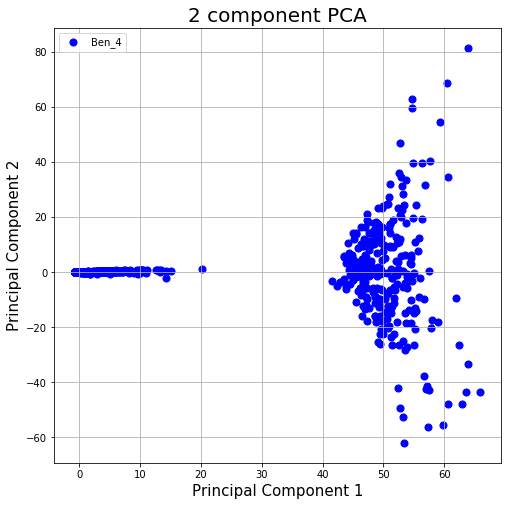

In [45]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Ben_4']
for target, color in zip(targets,colors):
    indicesToKeep = principalDf_frac['Rock_Type'] == target
    ax.scatter(principalDf_frac.loc[indicesToKeep, 'PC1']
               , principalDf_frac.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [46]:
from bokeh.plotting import figure

#output_file("PCA_1.html")

p = figure(x_range=columns,  plot_width = 800, plot_height=400, title="PCA for Dataset 1: Synthetically fractured porous media",
           toolbar_location=None, tools="", y_range= ranges.Range1d(start=0,end=100))

p.vbar(x=columns, top=var_per, width=0.9)

source = ColumnDataSource(dict(x=columns,y=var_per))
labels = LabelSet(x='x', y='y', text='y', level='glyph', source=source, x_offset = -13, y_offset = 0)
p.add_layout(labels)


show(p)

In [48]:
from bokeh.io import output_file, show, save
from bokeh.models import BasicTicker, ColorBar, LinearColorMapper, ColumnDataSource, PrintfTickFormatter
from bokeh.plotting import figure
from bokeh.transform import transform
from bokehheat import heat
from bokeh.io import show
from bokeh.palettes import Reds9, RdBu11, RdYlBu, Colorblind8, RdBu

x = heat.heatmap(df_matrix = df, ls_color_palette = RdBu11, r_low = -0.8, r_high = 0.8, s_z ="PCA for Dataset 1: Synthetically fractured porous media")

show(x)
save(x)


'C:\\Users\\admin\\AppData\\Local\\Temp\\tmpohytuokc.html'

### After PCA Components are chosen

In [49]:
km_frac_pca = KMeans(
    n_clusters=2, init='k-means++',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
y_km_frac_pca = km_frac_pca.fit_predict(X_PC_frac)

df_artificial_frac['Fracture_Label'] = y_km_frac_pca

#In the above, we have saved the labels obtained via k-means clustering in the processes dataframe. But we need to get the complete unfiltered dataset, and make all the removed contours = pores. So, lets try to merge.

# Rename the coplumns to replace all the spaces with '_'
cols = df_artificial_frac_complete.columns
cols = cols.map(lambda x: x.replace(' ', '_') if isinstance(x, (str, ' ')) else x)
df_artificial_frac_complete.columns = cols

print('Data import is complete for', len(rock_type), 'artificially fractured rock samples.')


#Merge the dataframes
df_merge = df_artificial_frac_complete.merge(df_artificial_frac,  how='outer', left_index = True, right_index = True)


col_drop = ['Rock_Type_y', 'Direction_y', 'Slice_Number_y',
       'Contour_Number_y', 'Contour_Perimeter_y', 'Contour_Area_y',
       'Angle_Ellipse_y', 'Aspect_Ratio_Ellipse_y', 'Aspect_Ratio_Rectangle_y',
       'Extent_Rectangle_y', 'Rotated_Rectangle_Angle_y', 'm00_y', 'm01_y',
       'm02_y', 'm03_y', 'm10_y', 'm11_y', 'm12_y', 'm20_y', 'm21_y', 'm30_y',
       'mu02_y', 'mu03_y', 'mu11_y', 'mu12_y', 'mu20_y', 'mu21_y', 'mu30_y',
       'nu02_y', 'nu03_y', 'nu11_y', 'nu12_y', 'nu20_y', 'nu21_y', 'nu30_y']
df_merge.drop(col_drop, axis=1, inplace=True)

merge_cols = ['Rock_Type', 'Direction', 'Slice_Number', 'Contour_Number',
       'Contour_Perimeter', 'Contour_Area', 'Angle_Ellipse',
       'Aspect_Ratio_Ellipse', 'Aspect_Ratio_Rectangle',
       'Extent_Rectangle', 'Rotated_Rectangle_Angle', 'm00', 'm01',
       'm02', 'm03', 'm10', 'm11', 'm12', 'm20', 'm21', 'm30',
       'mu02', 'mu03', 'mu11', 'mu12', 'mu20', 'mu21', 'mu30',
       'nu02', 'nu03', 'nu11', 'nu12', 'nu20', 'nu21', 'nu30',
       'Contour_Points', 'Fracture_Label']
df_merge.columns = merge_cols

Data import is complete for 1 artificially fractured rock samples.


In [50]:
len(X_PC_frac[y_km_frac_pca == 1, 0])

300

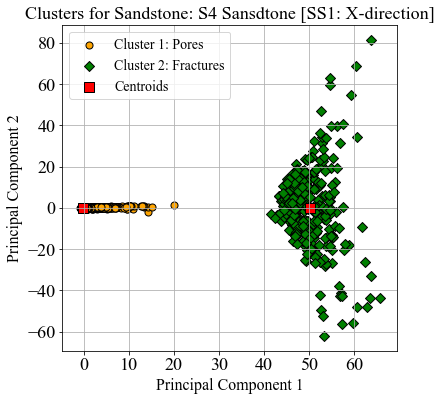

Fracture are 1 and Pores are 0


In [51]:
plt.figure(figsize = (6, 6))
csfont = {'fontname':'Times New Roman'}
plt.title("Clusters for Sandstone: S4 Sansdtone [SS1: X-direction]", fontsize = 18, **csfont)
plt.xlabel("Principal Component 1", fontsize = 16, **csfont)
plt.ylabel("Principal Component 2", fontsize = 16, **csfont)
plt.xticks(fontsize=18, **csfont)
plt.yticks(fontsize=18, **csfont)
plt.scatter(
    X_PC_frac[y_km_frac_pca == 0, 0], X_PC_frac[y_km_frac_pca == 0, 1],
    s=50, c='orange', edgecolor='black',
    marker='o',
    label='Cluster 1: Pores'
)

plt.scatter(
    X_PC_frac[y_km_frac_pca == 1, 0], X_PC_frac[y_km_frac_pca == 1, 1],
    s=50, c='green',
    marker='D', edgecolor='black',
    label='Cluster 2: Fractures'
)


# plot the centroids
plt.scatter(
    km_frac_pca.cluster_centers_[:, 0], km_frac_pca.cluster_centers_[:, 1],
    s=100, marker='s',
    c='red', edgecolor='black',
    label='Centroids'
)
import matplotlib.font_manager as font_manager
font = font_manager.FontProperties(family='Times New Roman', size=14)
plt.legend(scatterpoints=1, prop=font)

plt.grid()
plt.show()

print('Fracture are 1 and Pores are 0')

In [27]:
df_merge

,Rock_Type,Direction,Slice_Number,Contour_Number,Contour_Perimeter,Contour_Area,Angle_Ellipse,Aspect_Ratio_Ellipse,Aspect_Ratio_Rectangle,Extent_Rectangle,...,mu30,nu02,nu03,nu11,nu12,nu20,nu21,nu30,Contour_Points,Fracture_Label
0,Ben_4,x,1.0,0.0,4.000,0.0,-100.000,-100.000,3.000,0.000,...,0.000000e+00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,[[[295 299]]\n\n [[296 299]]\n\n [[297 299]]\n...,NaN
1,Ben_4,x,1.0,1.0,4.000,0.0,-100.000,-100.000,3.000,0.000,...,0.000000e+00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,[[[218 299]]\n\n [[219 299]]\n\n [[220 299]]\n...,NaN
2,Ben_4,x,1.0,2.0,6.000,0.0,0.000,0.000,4.000,0.000,...,0.000000e+00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,[[[106 299]]\n\n [[107 299]]\n\n [[108 299]]\n...,NaN
3,Ben_4,x,1.0,3.0,6.000,0.0,0.000,0.000,4.000,0.000,...,0.000000e+00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,[[[ 3 299]]\n\n [[ 4 299]]\n\n [[ 5 299]]\n...,NaN
4,Ben_4,x,1.0,4.0,9.657,6.0,90.000,0.535,1.667,0.400,...,0.000000e+00,0.046,0.000,0.000,0.000,0.139,0.000,0.000,[[[ 73 296]]\n\n [[ 74 295]]\n\n [[ 75 295]]\n...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100702,Ben_4,x,300.0,337.0,1897.499,9332.0,4.591,0.397,0.367,0.283,...,1.559538e+07,0.827,0.007,-0.006,0.001,0.028,-0.000,0.002,[[[134 0]]\n\n [[134 1]]\n\n [[134 2]]\n...,1.0
100703,Ben_4,x,300.0,338.0,40.142,42.0,91.526,0.382,2.667,0.438,...,-5.599240e+02,0.036,0.005,0.017,0.002,0.290,-0.021,-0.049,[[[112 0]]\n\n [[112 1]]\n\n [[112 2]]\n...,0.0
100704,Ben_4,x,300.0,339.0,127.255,248.0,98.326,0.378,2.471,0.347,...,-1.236382e+05,0.094,0.002,0.102,0.002,0.309,-0.025,-0.128,[[[ 76 0]]\n\n [[ 77 1]]\n\n [[ 76 2]]\n...,0.0
100705,Ben_4,x,300.0,340.0,4.000,0.0,-100.000,-100.000,3.000,0.000,...,0.000000e+00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,[[[52 0]]\n\n [[53 0]]\n\n [[54 0]]\n\n [[5...,NaN


In [29]:
df_merge = df_merge.fillna(0)

num_frac = [4]
for num in num_frac:
    col_name = 'Ben_{}'.format(num)
    df_frac = df_merge.loc[df_merge['Rock_Type'] == col_name]
    csv_name = 'D:\\Fracture Identification\\version_3\\Properties_Excel\\kmeans_pca_ben_acc{}_x.csv'.format(num)
    df_frac.to_csv(csv_name) 

In [30]:
def find_contour(image, cnt_num):
    # Copy
    image = image.copy()
    #input, gives all the contours, contour approximation compresses horizontal,
    #vertical, and diagonal segments and leaves only their end points. For example,
    #an up-right rectangular contour is encoded with 4 points.
    #Optional output vector, containing information about the image topology.
    #It has as many elements as the number of contours.
    #we dont need it
    contours, hierarchy = cv2.findContours(image, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    mask = np.zeros(image.shape, np.uint8)
    for numb in cnt_num:
        cnt = contours[int(numb)]
        cv2.drawContours(mask, [cnt], 0, 255, -1)
    return mask 

In [31]:
mask_x = 300
mask_y = 325
mask_z = 300

fracs = [1]
num_img = 4
rock_type = ['Ben_4']

for num_frac in fracs:
    csv_name = 'D:\\Fracture Identification\\version_3\\Properties_Excel\\kmeans_pca_ben_acc{}_x.csv'.format(num_img)
    df_frac = pd.read_csv(csv_name)
    
    matfile_name = 'D:\\Fracture Identification\\version_3\\Priliminary Samples\\Python_Mat_files\\ben{}_x.mat'.format(num_img)
    frac_matfile = sio.loadmat(matfile_name)
    frac_3D = frac_matfile['FinalImage']
    frac_3D_mask = np.zeros((mask_x, mask_y, mask_z), dtype = np.uint8)
    
    for num_slice in range(1, mask_z+1):
        df_frac_slice = df_frac.loc[df_frac['Slice_Number'] == num_slice]
        #fractures are identified by label = 1 or 2
        frac_details_np = df_frac_slice.loc[(df_frac_slice['Fracture_Label'] == 1), 'Contour_Number'].values
        
        frac_slice = frac_3D[0:mask_x, 0:mask_y, num_slice-1]
        mask_2D = np.zeros((mask_x, mask_y), dtype = np.uint8)
        mask_2D = find_contour(frac_slice, frac_details_np)

        frac_3D_mask[:,:,num_slice-1] = mask_2D
    
    frac_3D_mask[frac_3D_mask == 255] = 6

    matfile_name = 'D:\\Fracture Identification\\version_3\\Priliminary Samples\\Mat_files\\ben{}_x.mat'.format(num_img)
    org_frac_matfile = sio.loadmat(matfile_name)
    org_frac = org_frac_matfile['FinalImage']

    overall_frac = org_frac + frac_3D_mask
    overall_frac[overall_frac == 7] = 1
    print('The unique values in overall combined image is:', np.unique(overall_frac))
    
    overall_matfile = 'D:\\Fracture Identification\\version_3\\Priliminary Samples\\overall_ben{}_x.mat'.format(num_img)
    sio.savemat(overall_matfile, {'x':overall_frac})

The unique values in overall combined image is: [0 1 6]
